In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import shap

In [269]:
stats = pd.read_csv("Data_Stats.csv", index_col=0)

In [270]:
stats.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,dbpm,bpm,vorp,mov,mov_adj,_ID_NEW,Level_of_Impact,Quality_of_Impact,Wins_Contribution,Total_Stats
Column1,,,,,,,,,,,,,,,,,,,,,
143,Shaquille O'Neal,C,27,LAL,79,79,40.0,12.1,21.1,0.574,...,2.0,9.3,9.0,8.55,8.41,1,16.782683,17.16,287.990839,119.089656
641,Nikola Jokić,C,25,DEN,72,72,34.6,10.2,18.0,0.566,...,3.0,12.1,8.8,4.93,4.82,2,8.805278,16.02,141.060554,113.531904
663,Nikola Jokić,C,26,DEN,74,74,33.5,10.3,17.7,0.583,...,4.5,13.7,9.8,2.30,2.16,3,9.643915,16.56,159.703226,130.160376
929,James Harden,SG,28,HOU,72,72,35.4,9.0,20.1,0.449,...,1.4,9.9,7.7,8.48,8.21,4,15.195018,15.20,230.964278,102.463488
1030,Allen Iverson,SG,25,PHI,71,71,42.0,10.7,25.5,0.420,...,1.1,6.1,6.1,4.28,3.63,5,15.231232,11.96,182.165531,69.352232


In [271]:
stats.shape

(14697, 77)

In [272]:
stats.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Share Pts Won', 'Share Pts Max', 'Share pc', 'Team', 'Team W',
       'Team L', 'Team WL', 'Team GB', 'Team PS G', 'Team PA G', 'Team P Diff',
       'PTS_R', 'AST_R', 'STL_R', 'BLK_R', '3P_R', 'NPos', 'NTm',
       'Point_Contribution_PG', 'Rank_MVP', 'per', 'ts_pct',
       'fg3a_per_fga_pct', 'fta_per_fga_pct', 'orb_pct', 'drb_pct', 'trb_pct',
       'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws',
       'ws', 'ws_per_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'mov', 'mov_adj',
       '_ID_NEW', 'Level_of_Impact', 'Quality_of_Impact', 'Wins_Contribution',
       'Total_Stats'],
      dtype='object')

In [273]:
del stats['_ID_NEW']
del stats['NTm']
del stats['Team']
del stats['PTS_R']
del stats['AST_R']
del stats['STL_R']
del stats['BLK_R']
del stats['3P_R']
del stats['Point_Contribution_PG'] 

In [274]:
stats.shape

(14697, 68)

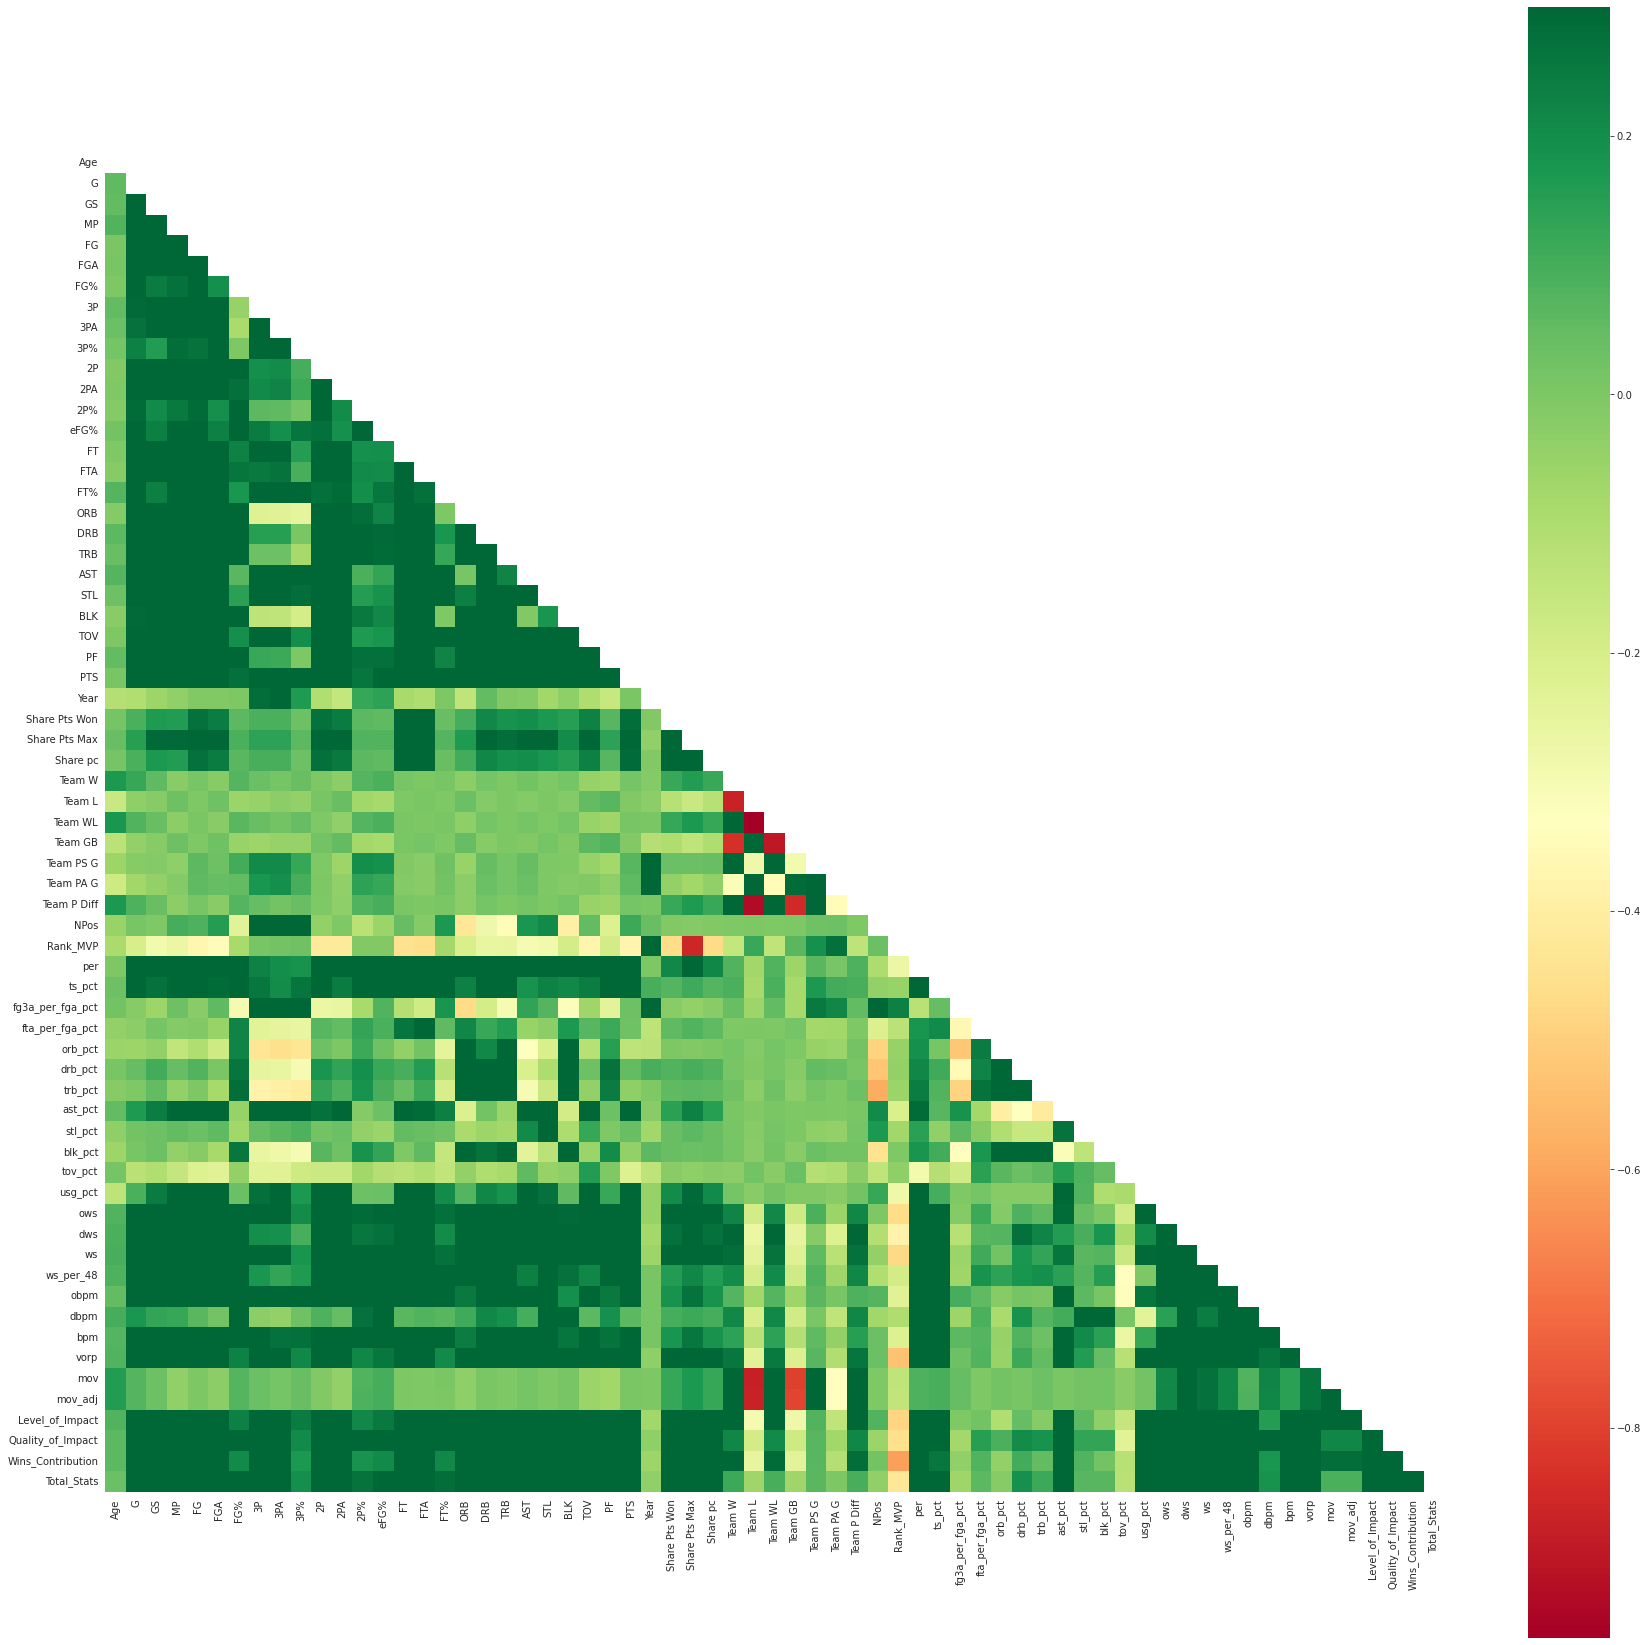

In [275]:
#correlations of each features
corr_matrix = stats.corr()

#plot heat map
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(30,30))
    ax = sns.heatmap(corr_matrix, mask=mask, vmax=.3, square=True,cmap="RdYlGn")

In [276]:
stats.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Share Pts Won', 'Share Pts Max', 'Share pc', 'Team W', 'Team L',
       'Team WL', 'Team GB', 'Team PS G', 'Team PA G', 'Team P Diff', 'NPos',
       'Rank_MVP', 'per', 'ts_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct',
       'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct',
       'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'dbpm',
       'bpm', 'vorp', 'mov', 'mov_adj', 'Level_of_Impact', 'Quality_of_Impact',
       'Wins_Contribution', 'Total_Stats'],
      dtype='object')

In [277]:
stats2 = stats.copy()
del stats2['Level_of_Impact']
del stats2['Quality_of_Impact']
del stats2['Wins_Contribution']
del stats2['Total_Stats']
train = stats2[~(stats2["Year"] == 2021)]
test = stats2[stats2["Year"] == 2021]

In [278]:
stats.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Share Pts Won', 'Share Pts Max', 'Share pc', 'Team W', 'Team L',
       'Team WL', 'Team GB', 'Team PS G', 'Team PA G', 'Team P Diff', 'NPos',
       'Rank_MVP', 'per', 'ts_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct',
       'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct',
       'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'dbpm',
       'bpm', 'vorp', 'mov', 'mov_adj', 'Level_of_Impact', 'Quality_of_Impact',
       'Wins_Contribution', 'Total_Stats'],
      dtype='object')

In [279]:
stats2.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Share Pts Won', 'Share Pts Max', 'Share pc', 'Team W', 'Team L',
       'Team WL', 'Team GB', 'Team PS G', 'Team PA G', 'Team P Diff', 'NPos',
       'Rank_MVP', 'per', 'ts_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct',
       'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct',
       'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'dbpm',
       'bpm', 'vorp', 'mov', 'mov_adj'],
      dtype='object')

In [280]:
predictors = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Team W', 'Team L',
       'Team WL', 'Team GB', 'Team PS G', 'Team PA G', 'Team P Diff', 'NPos',
        'per', 'ts_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct',
       'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct',
       'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'dbpm',
       'bpm', 'vorp', 'mov', 'mov_adj']

In [281]:
reg = Ridge(alpha=.1)

In [282]:
reg.fit(train[predictors],train["Share pc"])

Ridge(alpha=0.1)

In [283]:
predictions1 = reg.predict(test[predictors])#nupy array
predictions1 = pd.DataFrame(predictions1, columns=["predictions1"], index=test.index) # prints in a column

In [284]:
combination1 = pd.concat([test[["Player", "Share pc"]], predictions1], axis=1)

In [285]:
combination1.sort_values("Share pc", ascending=False).head(20)

,Player,Share pc,predictions1
Column1,,,
641,Nikola Jokić,0.961,0.200620
9018,Joel Embiid,0.580,0.087581
3843,Stephen Curry,0.449,0.105698
10338,Giannis Antetokounmpo,0.345,0.190437
1499,Chris Paul,0.138,0.055822
11449,Luka Dončić,0.042,0.151717
7759,Damian Lillard,0.038,0.090829
3707,Julius Randle,0.020,0.095985
3702,Derrick Rose,0.010,0.008603


In [286]:
combination1["Share pc"].value_counts()

0.000    525
0.001      3
0.961      1
0.580      1
0.449      1
0.345      1
0.138      1
0.042      1
0.038      1
0.020      1
0.010      1
0.008      1
0.005      1
0.003      1
Name: Share pc, dtype: int64

In [287]:
actual = combination1.sort_values("Share pc", ascending=False)
predicted = combination1.sort_values("predictions1", ascending=False)
actual["Rk"] = list(range(1,actual.shape[0]+1))
predicted["Predicted_Rk"] = list(range(1,predicted.shape[0]+1))

In [288]:
actual.merge(predicted, on="Player").head(10)

,Player,Share pc_x,predictions1_x,Rk,Share pc_y,predictions1_y,Predicted_Rk
0,Nikola Jokić,0.961,0.200620,1,0.961,0.200620,1
1,Joel Embiid,0.580,0.087581,2,0.580,0.087581,11
2,Stephen Curry,0.449,0.105698,3,0.449,0.105698,5
3,Giannis Antetokounmpo,0.345,0.190437,4,0.345,0.190437,2
4,Chris Paul,0.138,0.055822,5,0.138,0.055822,23
5,Luka Dončić,0.042,0.151717,6,0.042,0.151717,3
6,Damian Lillard,0.038,0.090829,7,0.038,0.090829,10
7,Julius Randle,0.020,0.095985,8,0.020,0.095985,8
8,Derrick Rose,0.010,0.008603,9,0.010,0.008603,141
9,Rudy Gobert,0.008,0.095585,10,0.008,0.095585,9


In [289]:
mean_squared_error(combination1["Share pc"], combination1["predictions1"])

0.00227343818573452

In [290]:
mean_absolute_error(combination1["Share pc"], combination1["predictions1"])

0.01783521644868725

In [291]:
def find_ap(combination1):
    actual = combination1.sort_values("Share pc", ascending=False).head(5)
    predicted = combination1.sort_values("predictions1", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index,row in predicted.iterrows():
        if row["Player"] in actual["Player"].values:
            found += 1
            ps.append(found / seen)
        seen += 1

    return sum(ps) / len(ps)

In [292]:
ap = find_ap(combination1)

In [293]:
ap

0.636205533596838

In [294]:
years = list(range(1991,2023))

In [295]:
aps = []
all_predictions = []
for year in years[5:]:
    train = stats2[stats2["Year"] < year]
    test = stats2[stats2["Year"] == year]
    reg.fit(train[predictors],train["Share pc"])
    predictions1 = reg.predict(test[predictors])
    predictions1 = pd.DataFrame(predictions1, columns=["predictions1"], index=test.index)
    combination1 = pd.concat([test[["Player", "Share pc", "Year"]], predictions1], axis=1)
    all_predictions.append(combination1)
    aps.append(find_ap(combination1))

In [296]:
sum(aps) / len(aps)

0.7766264771044185

In [297]:
def add_ranks(predictions1):
    predictions1 = predictions1.sort_values("predictions1", ascending=False)
    predictions1["Predicted_Rk"] = list(range(1,predictions1.shape[0]+1))
    predictions1 = predictions1.sort_values("Share pc", ascending=False)
    predictions1["Rk"] = list(range(1,predictions1.shape[0]+1))
    predictions1["Diff"] = (predictions1["Rk"] - predictions1["Predicted_Rk"])
    return predictions1

In [298]:
add_ranks(all_predictions[1])

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
1710,Karl Malone,0.857,1997,0.244374,2,1,-1
10976,Michael Jordan,0.832,1997,0.254515,1,2,1
970,Grant Hill,0.327,1997,0.220094,3,3,0
4912,Tim Hardaway,0.207,1997,0.121501,9,4,-5
8642,Glen Rice,0.117,1997,0.027310,60,5,-55
...,...,...,...,...,...,...,...
9456,Eric Snow,0.000,1997,0.007781,156,437,281
13760,Sam Cassell,0.000,1997,0.007900,155,438,283
13569,Terry Porter,0.000,1997,0.007945,154,439,285


In [299]:
def backtest(stats2, model, years, predictors):
    aps = []
    all_predictions = []
    for year in years:
        train = stats2[stats2["Year"] < year]
        test = stats2[stats2["Year"] == year]
        model.fit(train[predictors],train["Share pc"])
        predictions1 = model.predict(test[predictors])
        predictions1 = pd.DataFrame(predictions1, columns=["predictions1"], index=test.index)
        combination1 = pd.concat([test[["Player", "Share pc", "Year"]], predictions1], axis=1)
        combination1 = add_ranks(combination1)
        all_predictions.append(combination1)
        aps.append(find_ap(combination1))
    return sum(aps) / len(aps), aps, pd.concat(all_predictions)

In [300]:
mean_ap, aps, all_predictions = backtest(stats2, reg, years[5:], predictors)

In [301]:
mean_ap

0.7766264771044185

In [302]:
all_predictions

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
10962,Michael Jordan,0.986,1996,0.268826,1,1,0
10261,David Robinson,0.508,1996,0.257982,2,2,0
7645,Anfernee Hardaway,0.319,1996,0.128319,11,3,-8
5197,Hakeem Olajuwon,0.211,1996,0.197429,4,4,0
10965,Scottie Pippen,0.200,1996,0.110697,14,5,-9
...,...,...,...,...,...,...,...
655,DeMarcus Cousins,0.000,2022,0.002864,209,601,392
6191,Shaquille Harrison,0.000,2022,0.002843,210,602,392
11464,Frank Ntilikina,0.000,2022,0.002809,211,603,392


In [336]:
rf = RandomForestRegressor(n_estimators=50, random_state=1, min_samples_split=5)

mean_ap2, aps, all_predictions = backtest(stats2, rf, years[28:], predictors)

In [337]:
mean_ap2

0.8937698412698414

In [305]:
all_predictions

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
11978,Giannis Antetokounmpo,0.932,2019,0.560071,2,1,-1
10065,James Harden,0.768,2019,0.619428,1,2,1
1471,Paul George,0.352,2019,0.094498,10,3,-7
12253,Nikola Jokić,0.210,2019,0.149058,4,4,0
4361,Stephen Curry,0.173,2019,0.219934,3,5,2
...,...,...,...,...,...,...,...
12223,De'Anthony Melton,0.000,2022,0.000000,209,601,392
12222,Dakota Mathias,0.000,2022,0.000000,210,602,392
12221,DaQuan Jeffries,0.000,2022,0.000000,211,603,392


In [306]:
mean_squared_error(combination1["Share pc"], combination1["predictions1"])

0.0018682732353477898

In [307]:
mean_absolute_error(combination1["Share pc"], combination1["predictions1"])

0.017985998826241415

In [308]:
lr = LinearRegression()

In [339]:
mean_ap3, aps, all_predictions = backtest(stats2, lr, years[5:], predictors)

In [340]:
mean_ap3

0.7740198160337052

In [311]:
all_predictions

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
10962,Michael Jordan,0.986,1996,0.267208,1,1,0
10261,David Robinson,0.508,1996,0.258012,2,2,0
7645,Anfernee Hardaway,0.319,1996,0.129522,11,3,-8
5197,Hakeem Olajuwon,0.211,1996,0.197278,4,4,0
10965,Scottie Pippen,0.200,1996,0.110856,14,5,-9
...,...,...,...,...,...,...,...
11464,Frank Ntilikina,0.000,2022,0.002947,209,601,392
1906,Mo Bamba,0.000,2022,0.002692,210,602,392
11886,Miye Oni,0.000,2022,0.002681,211,603,392


In [312]:
mean_squared_error(combination1["Share pc"], combination1["predictions1"])

0.0018682732353477898

In [313]:
mean_absolute_error(combination1["Share pc"], combination1["predictions1"])

0.017985998826241415

In [314]:
def calculate_ml_scores(df):
    X = df.copy()
    y = X["Share pc"]

    X.drop('Share pc', axis=1, inplace=True)

    # Label encoding for categoricals
    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X.dtypes == int
    
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return X, y, mi_scores

In [315]:
stats2.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Share Pts Won', 'Share Pts Max', 'Share pc', 'Team W', 'Team L',
       'Team WL', 'Team GB', 'Team PS G', 'Team PA G', 'Team P Diff', 'NPos',
       'Rank_MVP', 'per', 'ts_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct',
       'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct',
       'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'dbpm',
       'bpm', 'vorp', 'mov', 'mov_adj'],
      dtype='object')

In [316]:
to_drop_mi = ['Player', 'Pos', 'Tm','Share Pts Won', 'Share Pts Max','Rank_MVP','ws_per_48','obpm']

In [317]:
master_table_mi = stats2.copy()
master_table_mi.drop(to_drop_mi, axis=1, inplace=True)

In [318]:
X, y, mi_scores = calculate_ml_scores(df=master_table_mi)

In [319]:
def plot_mi_scores(scores, figsize):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(width, scores)
    
    for index, value in enumerate(scores):
        plt.text(value +0.005 , index, str(round(value,2)))
    
    plt.yticks(width, ticks)    
    plt.title("Mutual Information Scores")

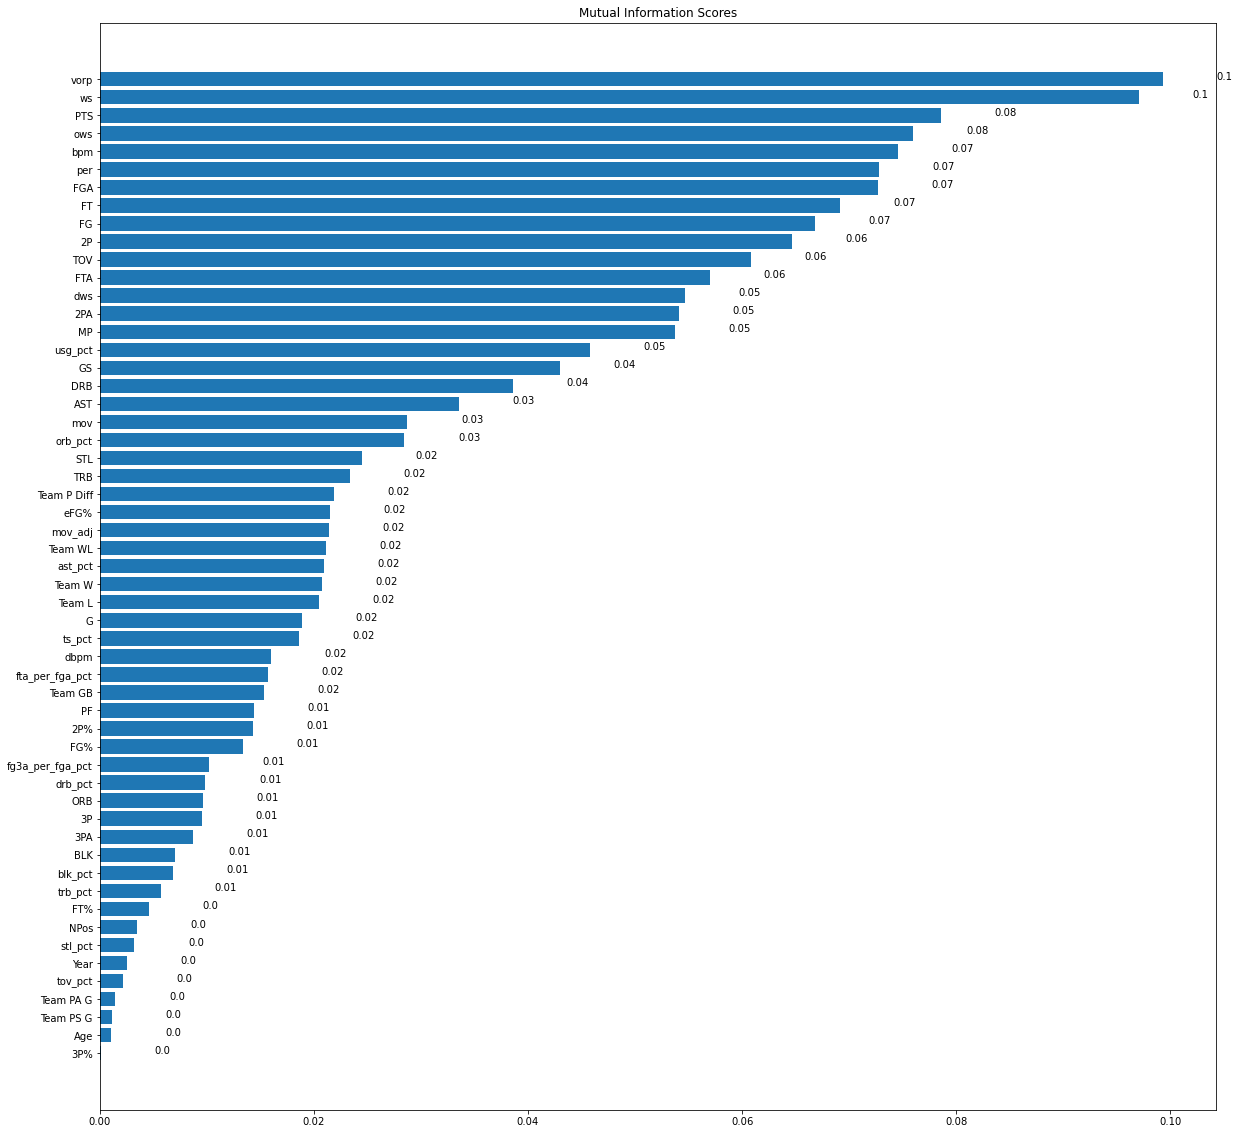

In [320]:
plot_mi_scores(mi_scores, figsize=(20,20))

In [321]:
predictors2 = ["vorp","bpm","per","FG","FTA","ws","PTS","ows","2P","2PA","FT","MP","FGA","TOV", "dws", "usg_pct"]

In [322]:
mean_ap4, aps, all_predictions = backtest(stats2, rf, years[28:], predictors2)

In [323]:
mean_ap4

0.8336810411810411

In [324]:
all_predictions

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
11978,Giannis Antetokounmpo,0.932,2019,0.660457,2,1,-1
10065,James Harden,0.768,2019,0.713139,1,2,1
1471,Paul George,0.352,2019,0.160102,5,3,-2
12253,Nikola Jokić,0.210,2019,0.174991,4,4,0
4361,Stephen Curry,0.173,2019,0.087863,11,5,-6
...,...,...,...,...,...,...,...
12220,Brandon Clarke,0.000,2022,0.000000,209,601,392
12222,Dakota Mathias,0.000,2022,0.000000,210,602,392
12232,Kyle Anderson,0.000,2022,0.000000,211,603,392


In [325]:
mean_ap5, aps, all_predictions = backtest(stats2, reg, years[5:], predictors2)

In [326]:
mean_ap5

0.8006559741062664

In [327]:
all_predictions

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
10962,Michael Jordan,0.986,1996,0.240548,1,1,0
10261,David Robinson,0.508,1996,0.229467,2,2,0
7645,Anfernee Hardaway,0.319,1996,0.130364,7,3,-4
5197,Hakeem Olajuwon,0.211,1996,0.166144,4,4,0
10965,Scottie Pippen,0.200,1996,0.109089,11,5,-6
...,...,...,...,...,...,...,...
6397,Quinndary Weatherspoon,0.000,2022,0.007139,209,601,392
4417,Willy Hernangómez,0.000,2022,0.007037,210,602,392
5591,Jay Scrubb,0.000,2022,0.007034,211,603,392


In [345]:
mean_ap6, aps, all_predictions = backtest(stats2, lr, years[5:], predictors2)

In [346]:
mean_ap6

0.8006529949366206

In [347]:
all_predictions

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
10962,Michael Jordan,0.986,1996,0.240616,1,1,0
10261,David Robinson,0.508,1996,0.229570,2,2,0
7645,Anfernee Hardaway,0.319,1996,0.130393,7,3,-4
5197,Hakeem Olajuwon,0.211,1996,0.166240,4,4,0
10965,Scottie Pippen,0.200,1996,0.109094,11,5,-6
...,...,...,...,...,...,...,...
6397,Quinndary Weatherspoon,0.000,2022,0.007139,209,601,392
4417,Willy Hernangómez,0.000,2022,0.007036,210,602,392
5591,Jay Scrubb,0.000,2022,0.007035,211,603,392


In [331]:
master_table_mi = stats.copy()

In [332]:
stats.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Share Pts Won', 'Share Pts Max', 'Share pc', 'Team W', 'Team L',
       'Team WL', 'Team GB', 'Team PS G', 'Team PA G', 'Team P Diff', 'NPos',
       'Rank_MVP', 'per', 'ts_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct',
       'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct',
       'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'dbpm',
       'bpm', 'vorp', 'mov', 'mov_adj', 'Level_of_Impact', 'Quality_of_Impact',
       'Wins_Contribution', 'Total_Stats'],
      dtype='object')

In [333]:
master_table_mi.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Share Pts Won', 'Share Pts Max', 'Share pc', 'Team W', 'Team L',
       'Team WL', 'Team GB', 'Team PS G', 'Team PA G', 'Team P Diff', 'NPos',
       'Rank_MVP', 'per', 'ts_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct',
       'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct',
       'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'dbpm',
       'bpm', 'vorp', 'mov', 'mov_adj', 'Level_of_Impact', 'Quality_of_Impact',
       'Wins_Contribution', 'Total_Stats'],
      dtype='object')

In [343]:
master_table_mi.drop(to_drop_mi, axis=1, inplace=True)
predictors3 = ["vorp","bpm","per","FG","FTA","ws","PTS","ows","2P","2PA","FT","MP","FGA","TOV", "dws", "usg_pct", "Level_of_Impact","Quality_of_Impact","Wins_Contribution","Total_Stats"]

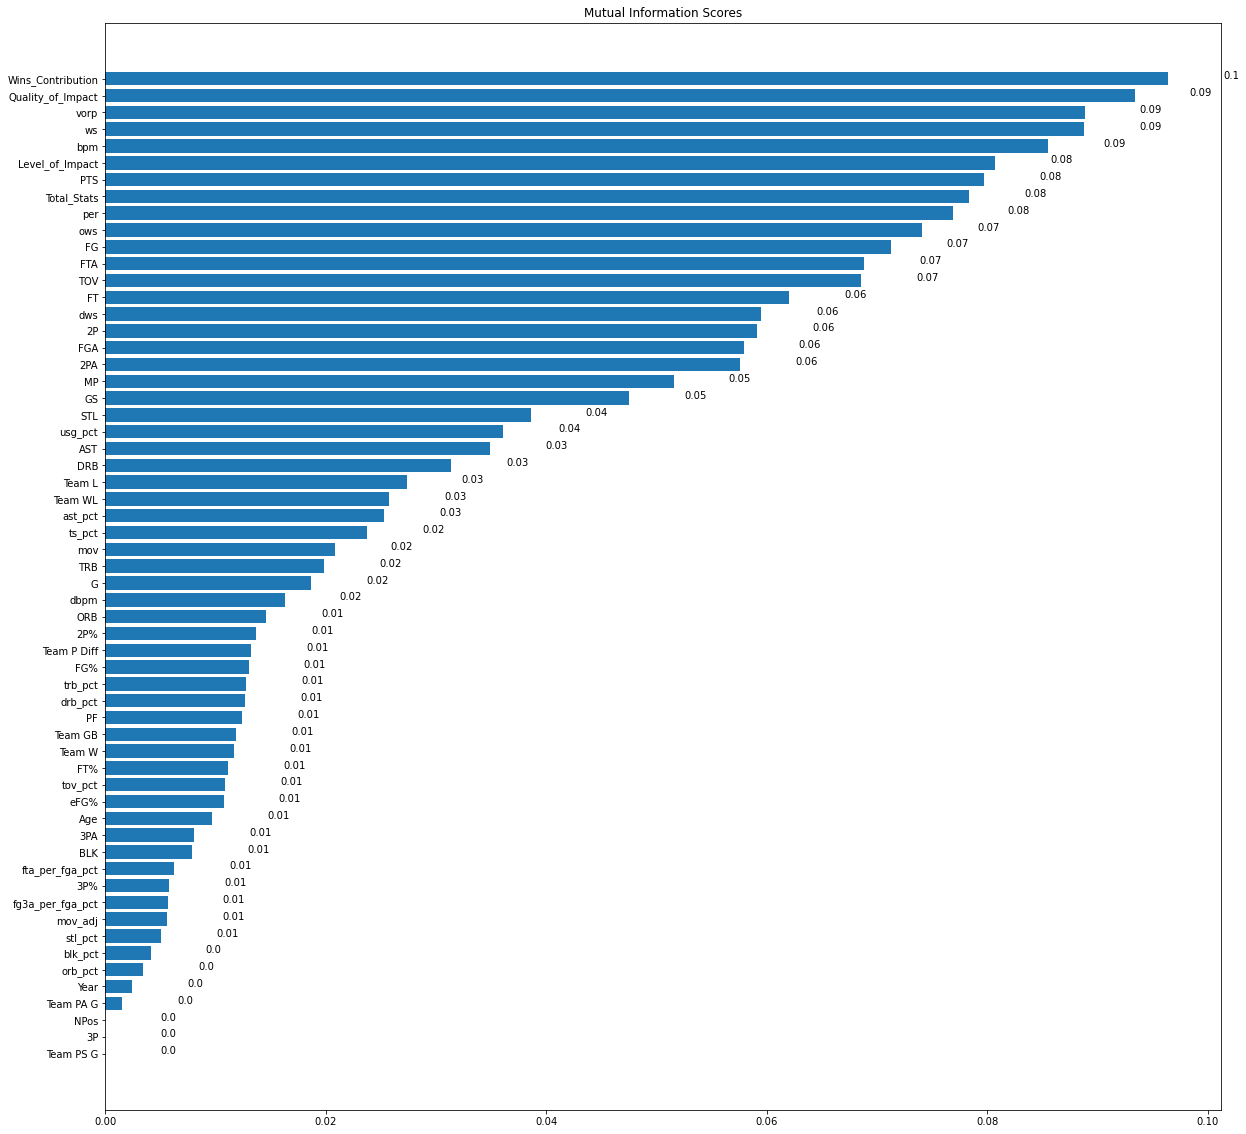

In [344]:
X, y, mi_scores = calculate_ml_scores(df=master_table_mi)
plot_mi_scores(mi_scores, figsize=(20,20))

In [351]:
mean_ap7, aps1, all_predictions1 = backtest(stats, reg, years[5:], predictors3)
mean_ap8, aps2, all_predictions2 = backtest(stats, lr, years[5:], predictors3)
mean_ap9, aps3, all_predictions3 = backtest(stats, rf, years[28:], predictors3)

In [352]:
mean_ap7,mean_ap8,mean_ap9

(0.8208045633046246, 0.8208047494203886, 0.859265873015873)

In [353]:
all_predictions1

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
10962,Michael Jordan,0.986,1996,0.886245,1,1,0
10261,David Robinson,0.508,1996,0.490785,2,2,0
7645,Anfernee Hardaway,0.319,1996,0.269794,4,3,-1
5197,Hakeem Olajuwon,0.211,1996,0.208374,6,4,-2
10965,Scottie Pippen,0.200,1996,0.245308,5,5,0
...,...,...,...,...,...,...,...
8239,Jemerrio Jones,0.000,2022,0.007339,209,601,392
11879,Greg Monroe,0.000,2022,0.007300,210,602,392
1860,Jahmi'us Ramsey,0.000,2022,0.007269,211,603,392


In [354]:
all_predictions2

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
10962,Michael Jordan,0.986,1996,0.886396,1,1,0
10261,David Robinson,0.508,1996,0.490945,2,2,0
7645,Anfernee Hardaway,0.319,1996,0.269781,4,3,-1
5197,Hakeem Olajuwon,0.211,1996,0.208502,6,4,-2
10965,Scottie Pippen,0.200,1996,0.245301,5,5,0
...,...,...,...,...,...,...,...
8239,Jemerrio Jones,0.000,2022,0.007338,209,601,392
11879,Greg Monroe,0.000,2022,0.007296,210,602,392
1860,Jahmi'us Ramsey,0.000,2022,0.007265,211,603,392


In [355]:
all_predictions3

,Player,Share pc,Year,predictions1,Predicted_Rk,Rk,Diff
Column1,,,,,,,
11978,Giannis Antetokounmpo,0.932,2019,0.441513,2,1,-1
10065,James Harden,0.768,2019,0.822315,1,2,1
1471,Paul George,0.352,2019,0.142011,4,3,-1
12253,Nikola Jokić,0.210,2019,0.217461,3,4,1
4361,Stephen Curry,0.173,2019,0.059146,8,5,-3
...,...,...,...,...,...,...,...
11889,Royce O'Neale,0.000,2022,0.000000,209,601,392
11888,Norvel Pelle,0.000,2022,0.000000,210,602,392
11887,Nickeil Alexander-Walker,0.000,2022,0.000000,211,603,392
